In [2]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
image_root_tr='/home/planck/NIDHI_SONI/Deep_lrn/train'
mask_root_tr='/home/planck/NIDHI_SONI/Deep_lrn/train_masks'
image_root_ts='/home/planck/NIDHI_SONI/Deep_lrn/test'
mask_root_ts='/home/planck/NIDHI_SONI/Deep_lrn/test_masks'

In [4]:
image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
mask_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


In [6]:
class Nidhi_Dataset(Dataset):
    def __init__(self, image_folder, mask_folder, image_transforms=None, mask_transforms=None):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_files = sorted(os.listdir(image_folder))
        self.mask_files = sorted(os.listdir(mask_folder))
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder, self.image_files[idx])
        mask_path = os.path.join(self.mask_folder, self.mask_files[idx])
        
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.image_transforms:
            image = self.image_transforms(image)
        if self.mask_transforms:
            mask = self.mask_transforms(mask)
        else:
            mask = torch.tensor(np.array(mask)).float() / 255
        
        return image, mask

In [7]:
dataset_tr = Nidhi_Dataset(image_root_tr, mask_root_tr, image_transforms, mask_transforms)
dataset_ts = Nidhi_Dataset(image_root_ts, mask_root_ts, image_transforms, mask_transforms)

# DataLoader
train_data_loader = DataLoader(dataset_tr, batch_size=32, shuffle=True)
test_data_loader = DataLoader(dataset_ts, batch_size=32, shuffle=True)

In [8]:
# Checking tensors Shapes

img,mask=dataset_tr[0]
img.shape,mask.shape

(torch.Size([3, 128, 128]), torch.Size([1, 128, 128]))

In [9]:

batch_size = 32
train_data_loader = DataLoader(dataset_tr, batch_size=batch_size, shuffle=True)
test_data_loader= DataLoader(dataset_ts, batch_size=batch_size, shuffle=True)

In [10]:

import torchvision.models as models


encoder_nidhi = models.mobilenet_v2(pretrained=True).features


/home/planck/miniconda3/envs/ravi/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/planck/miniconda3/envs/ravi/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
encoder_nidhi.eval() 
for param in encoder_nidhi.parameters():
    param.requires_grad = False 

In [12]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.encoder = models.mobilenet_v2(pretrained=True).features
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1280, 256, 4, 2, 1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# IoU Calculation
def calculate_iou(preds, labels):
    intersection = (preds & labels).float().sum((1, 2))
    union = (preds | labels).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()


def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0.0
        val_iou = 0.0
        model.eval()
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                preds = torch.sigmoid(outputs) > 0.5
                val_iou += calculate_iou(preds, masks > 0.5)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}, Val IoU: {val_iou / len(val_loader)}')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_nidhi = SegmentationModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_nidhi.parameters()), lr=0.001)


epochs = 10 
train_and_validate(model_nidhi, train_data_loader, test_data_loader, criterion, optimizer, epochs, device)


Epoch 1, Train Loss: 0.7127086150235143, Val Loss: 0.6931923528512319, Val IoU: 0.336466908454895
Epoch 2, Train Loss: 0.6931660524730024, Val Loss: 0.6931604395310084, Val IoU: 0.4035966098308563
Epoch 3, Train Loss: 0.6931552660876307, Val Loss: 0.6931551247835159, Val IoU: 0.41084057092666626
Epoch 4, Train Loss: 0.6931524749459892, Val Loss: 0.6931536744038264, Val IoU: 0.411501944065094
Epoch 5, Train Loss: 0.6931507813519445, Val Loss: 0.6931513845920563, Val IoU: 0.4172712564468384
Epoch 6, Train Loss: 0.6931499016696009, Val Loss: 0.6931509723265966, Val IoU: 0.416598379611969
Epoch 7, Train Loss: 0.6931493508404699, Val Loss: 0.6931503812472025, Val IoU: 0.41898608207702637
Epoch 8, Train Loss: 0.6931489048333004, Val Loss: 0.6931502819061279, Val IoU: 0.41818079352378845
Epoch 9, Train Loss: 0.6931485739247553, Val Loss: 0.6931496212879816, Val IoU: 0.41991037130355835
Epoch 10, Train Loss: 0.6931483766128277, Val Loss: 0.6931491792201996, Val IoU: 0.42342281341552734


In [ ]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'val_iou': [], 'val_accuracy': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss, val_iou, val_accuracy = 0.0, 0.0, 0.0
        model.eval()
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                preds = torch.sigmoid(outputs) > 0.5
                val_iou += calculate_iou(preds, masks > 0.5).cpu().item()

                #val_iou += calculate_iou(preds, masks > 0.5)  # Removed .item() here
                val_accuracy += calculate_accuracy(preds, masks > 0.5)  # And here
        
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_iou = val_iou / len(val_loader)
        epoch_val_accuracy = val_accuracy / len(val_loader)
        
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['val_iou'].append(epoch_val_iou)
        history['val_accuracy'].append(epoch_val_accuracy)
        
        print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val IoU: {epoch_val_iou:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}')
    
    return history


In [14]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 4))
    
    # Plot training and validation loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], 'r-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'b--', label='Val Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot IoU scores
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['val_iou'], 'g-', label='Val IoU')
    plt.title('Validation IoU Score')
    plt.xlabel('Epochs')
    plt.ylabel('IoU Score')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['val_accuracy'], 'm-', label='Val Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [18]:
history = train_and_validate(model_nidhi, train_data_loader, test_data_loader, criterion, optimizer, epochs, device)
plot_metrics(history)


NameError: name 'calculate_accuracy' is not defined

In [17]:
def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs') 
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['val_iou'], color='green', label='Val IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU Score')
    plt.title('IoU Score over Epochs')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['val_dice'], color='red', label='Val Dice Score')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.title('Dice Score over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Plot IoU and Dice scores
plt.plot(iou_scores, label='IoU')
plt.plot(dice_scores, label='Dice')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('IoU and Dice Scores')
plt.legend()
plt.show()




RuntimeError: "bitwise_and_cuda" not implemented for 'Float'

In [ ]:

def calculate_iou(preds, labels):
    # Ensure labels are boolean by applying a threshold if they are not already
    labels = labels > 0.5 if not labels.dtype == torch.bool else labels
    
    intersection = (preds & labels).float().sum((1, 2))
    union = (preds | labels).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()



def dice_score(outputs, targets, smooth=1e-8):
    intersection = torch.sum(outputs * targets)
    cardinality = torch.sum(outputs) + torch.sum(targets)
    dice = (2. * intersection + smooth) / (cardinality + smooth)
    return dice.item()





In [ ]:
# Define a function for plotting loss curves
def plot_losses(train_losses, val_losses, title):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
def visualize_predictions(model, loader, device, num_images=5):
    model.eval()
    images, masks = next(iter(loader))
    images, masks = images.to(device), masks.to(device)
    with torch.no_grad():
        preds = model(images)
        preds = torch.sigmoid(preds) > 0.5  # Threshold predictions
    images, preds, masks = images.cpu(), preds.cpu(), masks.cpu()

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(images[i].permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406]))
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


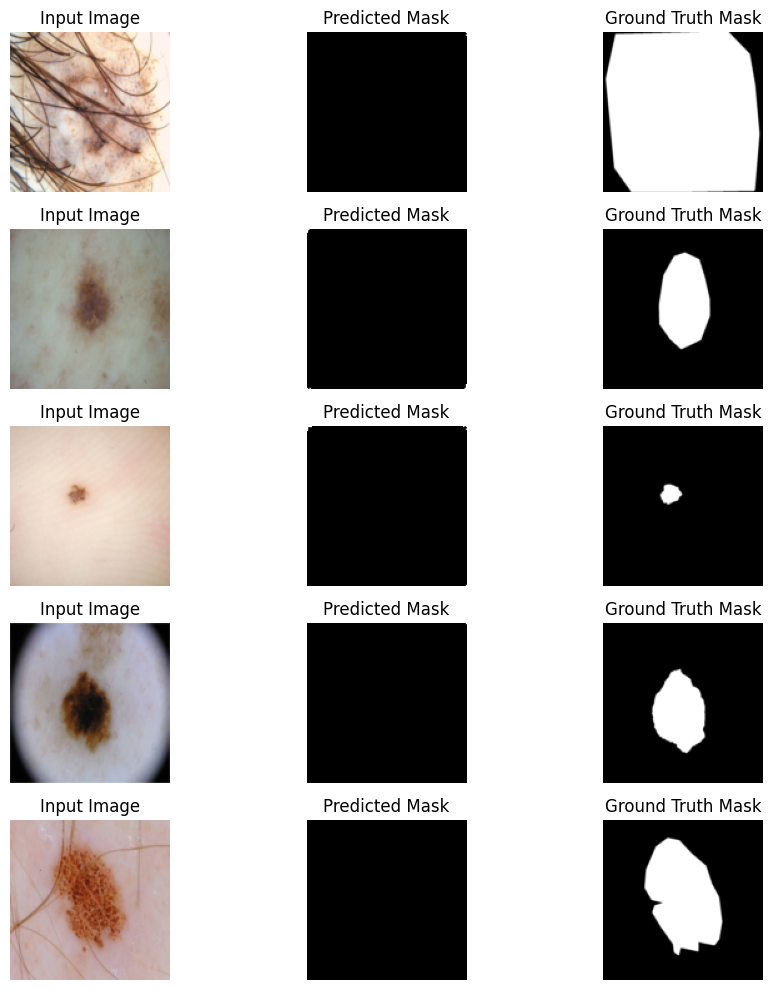

In [ ]:

visualize_predictions(model_nidhi, test_data_loader, device, num_images=5)
